---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Understanding and Predicting Property Maintenance Fines

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

## Preprocessing

###  Data Examination

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 50)

train = pd.read_csv("readonly/train.csv", engine='python')

In [2]:
train

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250301,325555,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,SANTA MARIA,NaN,1715.0,MEYERS,DETROIT,MI,48235,NaN,USA,2010-12-02 11:00:00,2015-01-06 09:00:00,9-1-43(a) - (Structu,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
250302,325557,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,MI,48235,NaN,USA,2010-12-02 11:00:00,2015-01-06 09:00:00,9-1-43(a) - (Structu,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
250303,325562,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,10701.0,MEYERS RD,NaN,1715.0,MEYERS,DETROIT,MI,48235,NaN,USA,2010-12-02 11:00:00,2015-01-06 09:00:00,9-1-43(a) - (Structu,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
250304,325559,"Buildings, Safety Engineering & Env Department","Bush, Wesley",WESTGATE TERRACE APARTMENTS LLC,1

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

In [4]:
pd.set_option("display.max_rows", 50)
train.isnull().sum()

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
b

In [5]:
addresses = pd.read_csv('readonly/addresses.csv')
latlons = pd.read_csv('readonly/latlons.csv')

In [6]:
pd.set_option("display.max_rows", 10)
addresses

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"
...,...,...
311302,376496,"12032 santa rosa, Detroit MI 48204"
311303,376497,"12032 santa rosa, Detroit MI 48204"
311304,376499,"11832 kilbourne, Detroit MI 48213"
311305,376500,"11848 kilbourne, Detroit MI 48213"


In [7]:
addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311307 entries, 0 to 311306
Data columns (total 2 columns):
ticket_id    311307 non-null int64
address      311307 non-null object
dtypes: int64(1), object(1)
memory usage: 4.8+ MB


In [8]:
addresses.isnull().sum()

ticket_id    0
address      0
dtype: int64

In [9]:
pd.set_option("display.max_rows", 10)
latlons

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295
...,...,...,...
121764,"14267 sorrento, Detroit MI",42.392339,-83.172412
121765,"9359 vaughan, Detroit MI",42.363781,-83.237494
121766,"5911 courville, Detroit MI",42.409321,-82.943282
121767,"14545 wyoming, Detroit MI",42.395836,-83.159670


### Data Preprocessing and Feature Selection

In [10]:
train_copy = train.copy()
addresses_copy = addresses.copy()
latlons_copy = latlons.copy()

# Drop the data rows without compliance result
train_copy = train_copy.dropna(subset=['compliance'])

# Keep only the data within USA
train_copy = train_copy[train_copy['country']=='USA']

# merge latlons and addresses with data
train_copy = pd.merge(train_copy, pd.merge(addresses_copy, latlons_copy, on='address'), on='ticket_id')

In [11]:
train_copy

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,CA,908041512,NaN,USA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,MI,48038,NaN,USA,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,855.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493
4,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,MI,48211,NaN,USA,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159864,285106,Department of Public Works,"Zizi, Josue","LUNDY, ANTONIO R",20009.0,NORTHLAWN,NaN,18715.0,MARLOWE,DETROIT,MI,48235,NaN,USA,2011-12-27 14:50:00,2012-02-03 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,0.0,250.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"20009 northlawn, Detroit MI",42.440228,-83.154829
159865,284650,Department of Public Works,"Lusk, Gertrina","HARDAWAY, WILLIE",15725.0,STEEL,NaN,NaN,P.O. BOX 27125,DETROIT,MI,48227,NaN,USA,2011-12-29 09:50:00,2012-01-09 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,0.0,1130.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0,"15725 steel, Detroit MI",42.406293,-83.171850
159866,285125,Department of Public Works,"Bell, Maydell","CHRISTIAN CHURCH, BRIGHT STAR",7152.0,CHICAGO,NaN,7152.0,W. CHICAGO,DETROIT,MI,48204,NaN,USA,2011-12-29 09:30:00,2012-01-25 09:00:00,22-2-88(b),Allowing

In [13]:
# Select the features that I think relevant
my_features = ['agency_name',
            'violation_code',
            'disposition',   
            'fine_amount', 
            'admin_fee',
            'state_fee', 
            'late_fee', 
            'discount_amount', 
            'clean_up_cost',
            'judgment_amount', 
            'lat',
            'lon',   
            'compliance']

# features that may be relevant as well:
# 'violation_street_name'
# info for Mailing address of the violator
# time difference between ticket_issued_date and hearing_date 

In [14]:
pd.set_option("display.max_rows", 10)
train_copy = train_copy[my_features]
train_copy.dropna(subset=['compliance'])

train_copy.astype({'compliance': 'int32'})

,agency_name,violation_code,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon,compliance
0,"Buildings, Safety Engineering & Env Department",9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,42.390729,-83.124268,0
1,"Buildings, Safety Engineering & Env Department",61-63.0600,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.326937,-83.135118,1
2,"Buildings, Safety Engineering & Env Department",9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,42.145257,-83.208233,0
3,"Buildings, Safety Engineering & Env Department",61-63.0500,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.433466,-83.023493,0
4,"Buildings, Safety Engineering & Env Department",61-63.0100,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,42.388641,-83.037858,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159864,Department of Public Works,22-2-88(b),Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,42.440228,-83.154829,0
159865,Department of Public Works,22-2-88(b),Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,42.406293,-83.171850,0
159866,Department of Public Works,22-2-88(b),Responsible by Default,500.0,20.0,10.0,50.0,0.0,0.0,580.0,42.366529,-83.141897,0
159867,Department of Public Works,22-2-61,Responsible by Determination,200.0,20.0,10.0,0.0,0.0,0.0,230.0,42.422081,-83.038656,1


In [15]:
pd.set_option("display.max_rows", 20)
train_copy.isnull().sum()

agency_name        0
violation_code     0
disposition        0
fine_amount        0
admin_fee          0
state_fee          0
late_fee           0
discount_amount    0
clean_up_cost      0
judgment_amount    0
lat                2
lon                2
compliance         0
dtype: int64

In [16]:
train_copy = train_copy.fillna(train_copy.mode().iloc[0])

In [17]:
train_copy.isnull().sum()

agency_name        0
violation_code     0
disposition        0
fine_amount        0
admin_fee          0
state_fee          0
late_fee           0
discount_amount    0
clean_up_cost      0
judgment_amount    0
lat                0
lon                0
compliance         0
dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder

# Encode the non-digit features
label_encoder = LabelEncoder()
train_copy['agency_name_N'] = label_encoder.fit_transform(train_copy['agency_name'])


label_encoder = LabelEncoder()
train_copy['violation_code_N'] = label_encoder.fit_transform(train_copy['violation_code'])

label_encoder = LabelEncoder()
train_copy['disposition_N'] = label_encoder.fit_transform(train_copy['disposition'])

train_copy.drop(['agency_name', 'violation_code', 'disposition'], axis=1, inplace=True)

In [19]:
train_copy

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon,compliance,agency_name_N,violation_code_N,disposition_N
0,250.0,20.0,10.0,25.0,0.0,0.0,305.0,42.390729,-83.124268,0.0,0,143,2
1,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.326937,-83.135118,1.0,0,74,3
2,250.0,20.0,10.0,25.0,0.0,0.0,305.0,42.145257,-83.208233,0.0,0,143,2
3,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.433466,-83.023493,0.0,0,73,2
4,100.0,20.0,10.0,10.0,0.0,0.0,140.0,42.388641,-83.037858,0.0,0,72,2
5,100.0,20.0,10.0,10.0,0.0,0.0,140.0,42.388641,-83.037858,0.0,0,72,2
6,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.435773,-82.963348,0.0,0,74,2
7,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.395765,-83.022333,0.0,0,74,2
8,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.440190,-83.180488,0.0,0,74,2
9,750.0,20.0,10.0,75.0,0.0,0.0,855.0,42.399222,-83.023161,0.0,0,74,2


## Different Machine Learning Models

### Baseline Model with Logistic Regression

In [20]:
from sklearn.model_selection import train_test_split
X = train_copy.drop('compliance', axis=1)
y = train_copy['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression().fit(X_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# accuracy, precision, recall, F1 score
accuracy = lr.score(X_test_scaled, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

accuracy, precision, recall, f1_score

(0.92789231385108084,
 0.68000000000000005,
 0.011724137931034483,
 0.02305084745762712)

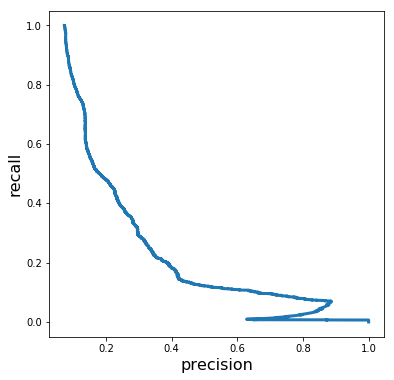

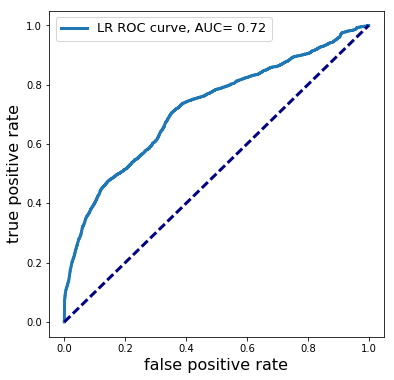

roc_auc:  0.720657286887


In [23]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

y_scores_lr = lr.decision_function(X_test_scaled)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores_lr)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores_lr)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(precision, recall, lw=3,  label='Recall-Precision curve')
plt.xlabel("precision", fontsize=16)
plt.ylabel("recall", fontsize=16)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=3, label='LR ROC curve, AUC= {:0.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel("false positive rate", fontsize=16)
plt.ylabel("true positive rate", fontsize=16)
plt.legend(loc='best', fontsize=13)
plt.show()

print("roc_auc: ", roc_auc )

### Tree-based model: Gradient Boosting Decision Trees

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

gbc = GradientBoostingClassifier().fit(X_scaled, y_train)
y_pred = gbc.predict(X_test_scaled)

# accuracy, precision, recall, F1 score
accuracy = gbc.score(X_test_scaled, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

accuracy, precision, recall, f1_score

(0.94383006405124104,
 0.9109159347553325,
 0.25034482758620691,
 0.39275087909115503)

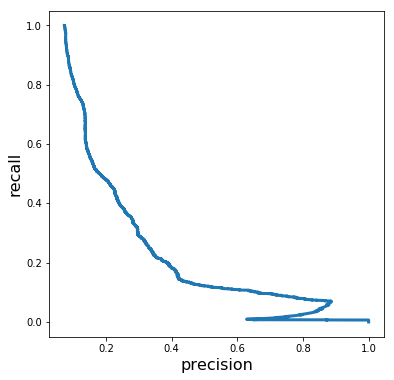

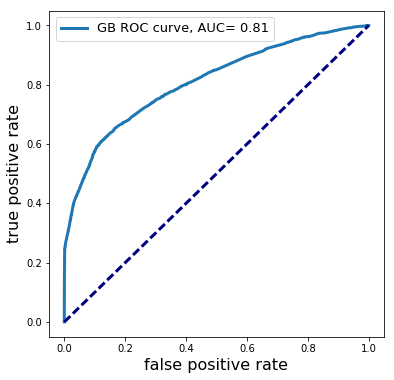

roc_auc:  0.80882429961


In [28]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

y_scores_gbc = gbc.decision_function(X_test_scaled)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores_lr)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores_gbc)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(precision, recall, lw=3,  label='Recall-Precision curve')
plt.xlabel("precision", fontsize=16)
plt.ylabel("recall", fontsize=16)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=3, label='GB ROC curve, AUC= {:0.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel("false positive rate", fontsize=16)
plt.ylabel("true positive rate", fontsize=16)
plt.legend(loc='best', fontsize=13)
plt.show()

print("roc_auc: ", roc_auc )

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# alternative metric to optimize over grid parameters: AUC
grid_values = {'learning_rate': [0.2, 0.5, 1], 'max_depth': [4,5,6]}
grid_clf_auc = GridSearchCV(gbc, param_grid = grid_values, scoring = 'roc_auc', cv=3, verbose=3)
grid_clf_auc.fit(X_scaled, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test_scaled) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.2, max_depth=4 ..................................
[CV] ... learning_rate=0.2, max_depth=4, score=0.808044, total=  11.1s
[CV] learning_rate=0.2, max_depth=4 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV] ... learning_rate=0.2, max_depth=4, score=0.816403, total=  11.2s
[CV] learning_rate=0.2, max_depth=4 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s


[CV] ... learning_rate=0.2, max_depth=4, score=0.815488, total=  10.9s
[CV] learning_rate=0.2, max_depth=5 ..................................
[CV] ... learning_rate=0.2, max_depth=5, score=0.808127, total=  14.1s
[CV] learning_rate=0.2, max_depth=5 ..................................
[CV] ... learning_rate=0.2, max_depth=5, score=0.817907, total=  14.5s
[CV] learning_rate=0.2, max_depth=5 ..................................
[CV] ... learning_rate=0.2, max_depth=5, score=0.817771, total=  15.3s
[CV] learning_rate=0.2, max_depth=6 ..................................
[CV] ... learning_rate=0.2, max_depth=6, score=0.808997, total=  18.9s
[CV] learning_rate=0.2, max_depth=6 ..................................
[CV] ... learning_rate=0.2, max_depth=6, score=0.817873, total=  18.8s
[CV] learning_rate=0.2, max_depth=6 ..................................
[CV] ... learning_rate=0.2, max_depth=6, score=0.816921, total=  18.8s
[CV] learning_rate=0.5, max_depth=4 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  6.7min finished


Test set AUC:  0.815756787154
Grid best parameter (max. AUC):  {'learning_rate': 0.2, 'max_depth': 5}
Grid best score (AUC):  0.8146016851


### Tree-based model: Extreme Gradient Boosting (XGBoost) Ensemble

### Tree-based model: LGBM

### Tree-based model: Random Forests

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc

rfc = RandomForestClassifier()

grid_values = {'n_estimators': [10,50,100], 'max_depth': [3,4,5] } 
grid_clf = GridSearchCV(rfc, param_grid = grid_values, scoring = 'roc_auc', cv=3, verbose=3)
grid_clf.fit(X_scaled, y_train)

print('Grid best parameter (max. AUC): ', grid_clf.best_params_)
print('Grid best score (AUC): ', grid_clf.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, n_estimators=10 ....................................
[CV] ..... max_depth=3, n_estimators=10, score=0.790863, total=   0.6s
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ..... max_depth=3, n_estimators=10, score=0.803436, total=   0.6s
[CV] max_depth=3, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] ..... max_depth=3, n_estimators=10, score=0.791368, total=   0.5s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..... max_depth=3, n_estimators=50, score=0.791811, total=   2.5s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..... max_depth=3, n_estimators=50, score=0.800936, total=   2.6s
[CV] max_depth=3, n_estimators=50 ....................................
[CV] ..... max_depth=3, n_estimators=50, score=0.803033, total=   2.6s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .... max_depth=3, n_estimators=100, score=0.793894, total=   5.4s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .... max_depth=3, n_estimators=100, score=0.808336, total=   4.9s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .... max_depth=3, n_estimators=100, score=0.797098, total=   5.0s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.6min finished


Grid best parameter (max. AUC):  {'max_depth': 5, 'n_estimators': 100}
Grid best score (AUC):  0.806249310256


### Summary

1. The logistic regression model serves as a baseline model. The AUC value is 0.721 which is not considered an acceptable score.
2. Random forests model yields a AUC score of 0.806 in the cross validation.
3. The great boosting decision tree model with default parameters yields a slightly better AUC of 0.809 in the cross validation.
4. Grid Value Search slightly improves the AUC score to 0.815 with beset parameters {max_depth': 5, 'n_estimators': 100}. Could be even higher with further tuned parameters.

## Submission

In [59]:
import pandas as pd
import numpy as np

def blight_model():
    
    # Your code here
    from sklearn.preprocessing import LabelEncoder
    from sklearn import preprocessing
    from sklearn.ensemble import GradientBoostingClassifier
    
    pd.reset_option("display.max_columns") #reset
    
    # load data
    train = pd.read_csv("train.csv", engine='python')
    test = pd.read_csv("test.csv", engine='python')
    addresses = pd.read_csv('addresses.csv')
    latlons = pd.read_csv('latlons.csv')
    
    # Preprocessing
    # Drop the data rows without compliance result
    train = train.dropna(subset=['compliance'])
    
    # Keep only the data within USA
    train = train[train['country']=='USA']
    test = test[test['country']=='USA']
    
    # merge latlons and addresses with data
    train = pd.merge(train, pd.merge(addresses, latlons, on='address'), on='ticket_id')  
    test = pd.merge(test, pd.merge(addresses, latlons, on='address'), on='ticket_id')
    
    # Select the features that I think relevant
    features = ['ticket_id',
            'agency_name',
            'violation_code',
            'disposition',   
            'fine_amount', 
            'admin_fee',
            'state_fee', 
            'late_fee', 
            'discount_amount', 
            'clean_up_cost',
            'judgment_amount', 
            'lat',
            'lon',   
            'compliance']
    
    train = train[features]
    test = test[features[0 : -1]]
    
    train.dropna(subset=['compliance'])
    train.astype({'compliance': 'int32'})
    
    train = train.fillna(train.mode().iloc[0])
    test = test.fillna(test.mode().iloc[0])
    
    # Set index to be the id
    train.index = train['ticket_id']
    test.index = test['ticket_id'] 
    
    # Encode the non-digit features    
    label_encoder = LabelEncoder()
    label_encoder.fit(train['agency_name'].append(test['agency_name'], ignore_index=True))
    train['agency_name'] = label_encoder.transform(train['agency_name'])
    test['agency_name'] = label_encoder.transform(test['agency_name'])
    
    label_encoder = LabelEncoder()
    label_encoder.fit(train['violation_code'].append(test['violation_code'], ignore_index=True))
    train['violation_code'] = label_encoder.transform(train['violation_code'])
    test['violation_code'] = label_encoder.transform(test['violation_code'])

    label_encoder = LabelEncoder()
    label_encoder.fit(train['disposition'].append(test['disposition'], ignore_index=True))
    train['disposition'] = label_encoder.transform(train['disposition'])
    test['disposition'] = label_encoder.transform(test['disposition'])
    
    X_train = train.drop('compliance', axis=1)
    y_train = train['compliance']

#     scaler = preprocessing.MinMaxScaler().fit(X_train.append(test))
#     X_train = scaler.transform(X_train)
#     test = scaler.transform(test)
    
    # Train the model
    gbc = GradientBoostingClassifier().fit(X_train, y_train)
    y_pred = gbc.predict(test)
    y_score = gbc.predict_proba(test)[:,1]   
    
    return pd.DataFrame(y_score, test['ticket_id']) # Your answer here

In [33]:
blight_model()

,0
ticket_id,
284932,0.112322
285362,0.026333
285361,0.094639
285338,0.102154
285346,0.105263
285345,0.102154
285347,0.088303
285342,0.929434
285530,0.026731


### Submission Result: AUC = 0.789 and was accepted.